Задание:
1. Модель должна научиться классифицировать текст
2. Должны выполнены три реализации модели. Реализации должны быть основаны на использовании:
    - одномерной сверточной нейросети
    - рекуррентной нейросети LSTM
    - рекуррентной нейросети GRU
3. Выполнить сравнение полученных результатов и сделать вывод

Исходные данные:
- для обучения: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
- для тестирования: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
- имена классов: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from transformers import AutoTokenizer

In [2]:
# import os
# from pathlib import Path
# import requests
from utils import check_data_path

In [3]:
# from tqdm import tqdm
# from sklearn.metrics import f1_score, accuracy_score
# from matplotlib import pyplot as plt
# import torch
from trainer import Trainer

In [4]:
# import torch
# import torch.nn as nn
from model import TextCNN, TextLSTM, TextGRU

In [5]:
import pandas as pd


# Data check

In [6]:
PATH_TO_DATA = './data'


In [7]:
links = {
    'train.csv': 'https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv',
    'test.csv': 'https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv',
    'classes.txt': 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt'
}

In [8]:
check_data_path(PATH_TO_DATA, links)
# expecting 
# data/train.csv
# data/test.csv
# data/classes.txt

'Ok. All files exist.'

# Data things

In [9]:
df = pd.read_csv(PATH_TO_DATA + '/train.csv', header=None, names=["class", "description", "text"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   class        120000 non-null  int64 
 1   description  120000 non-null  object
 2   text         120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [11]:
df_test = pd.read_csv(PATH_TO_DATA + '/test.csv', header=None, names=["class", "description", "text"])

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        7600 non-null   int64 
 1   description  7600 non-null   object
 2   text         7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [13]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [15]:
# max_length = max(df["text"].apply(lambda x: len(tokenizer.tokenize(str(x)))))
# max_length

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        """
        Инициализация датасета с предварительной токенизацией.
        
        :param dataframe: pandas.DataFrame, содержащий данные с текстами и метками.
        :param tokenizer: токенизатор (например, Hugging Face Tokenizer).
        :param max_length: максимальная длина токенизированного текста.
        """
        if not {"text", "class"}.issubset(dataframe.columns):
            raise ValueError("DataFrame должен содержать колонки 'text' и 'class'")
        
        self.data = []
        self.max_length = max_length

        for idx, row in dataframe.iterrows():
            text = row["text"]
            label = row["class"]

            # Токенизация текста
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )

            # Вычисление длины текста до паддинга
            input_ids = encoded["input_ids"].squeeze(0)
            attention_mask = encoded["attention_mask"].squeeze(0)
            length = attention_mask.sum().item()  # Сумма единиц в attention_mask

            self.data.append({
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "length": length,
                "label": torch.tensor(label, dtype=torch.long),
            })

    def __len__(self):
        """
        Возвращает количество элементов в датасете.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Возвращает данные по индексу.
        
        :param idx: индекс элемента.
        :return: input_ids, длину текста и метку.
        """
        return self.data[idx]['input_ids'], self.data[idx]['length'], self.data[idx]['label'] - 1

In [18]:
train_dataset = NewsDataset(dataframe=df, tokenizer=tokenizer, max_length=370)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [19]:
test_dataset = NewsDataset(dataframe=df_test, tokenizer=tokenizer, max_length=370)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Models

In [20]:
tcnn = TextCNN(vocab_size=tokenizer.vocab_size,
               embed_dim=768, 
               num_classes=4,
               kernel_sizes=[3,4,5], 
               num_filters=32).to(device=DEVICE)


hd = 128
lstm = TextLSTM(vocab_size=tokenizer.vocab_size,
                embed_dim=768,
                hidden_dim=hd,
                num_classes=4
                ).to(DEVICE)

gru = TextGRU(vocab_size=tokenizer.vocab_size,
                embed_dim=768,
                hidden_dim=hd,
                num_classes=4).to(DEVICE)


c:\Anaconda\envs\pip-torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Train

In [33]:
model = gru

In [34]:
EPOCHS = 15
learning_rate = 5e-4 # С ветерком перелетим локальные минимумы 😎
total_steps = len(train_dataloader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
# from adabelief_pytorch import AdaBelief
# optimizer = AdaBelief(lstm.parameters(), lr=learning_rate, eps=learning_rate, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=False, rectify=True, print_change_log = False)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate , total_steps=total_steps, pct_start=0.1, anneal_strategy='linear') # Красивая кривая будет)

In [35]:
trainer = Trainer(model = model,
                  optimizer = optimizer,
                  criterion = criterion,
                  train_loader = train_dataloader, 
                  val_loader=test_dataloader,
                  device = DEVICE,
                  scheduler = scheduler)
trainer.fit(EPOCHS)

Validating: 100%|██████████| 60/60 [00:00<00:00, 136.41it/s]


Validation Loss: 1.3220, Accuracy: 0.3870, F1 Score: 0.3793
Epoch 1/15 - Train Loss: 1.3718, Val Loss: 1.3220, Acc: 0.3870, F1: 0.3793


Validating: 100%|██████████| 60/60 [00:00<00:00, 135.75it/s]


Validation Loss: 1.2280, Accuracy: 0.4638, F1 Score: 0.4592
Epoch 2/15 - Train Loss: 1.2849, Val Loss: 1.2280, Acc: 0.4638, F1: 0.4592


Validating: 100%|██████████| 60/60 [00:00<00:00, 138.01it/s]


Validation Loss: 1.0897, Accuracy: 0.5389, F1 Score: 0.5331
Epoch 3/15 - Train Loss: 1.1700, Val Loss: 1.0897, Acc: 0.5389, F1: 0.5331


Validating: 100%|██████████| 60/60 [00:00<00:00, 133.93it/s]


Validation Loss: 0.8343, Accuracy: 0.6538, F1 Score: 0.6509
Epoch 4/15 - Train Loss: 0.9669, Val Loss: 0.8343, Acc: 0.6538, F1: 0.6509


Validating: 100%|██████████| 60/60 [00:00<00:00, 136.47it/s]


Validation Loss: 0.7093, Accuracy: 0.7051, F1 Score: 0.7037
Epoch 5/15 - Train Loss: 0.7587, Val Loss: 0.7093, Acc: 0.7051, F1: 0.7037


Validating: 100%|██████████| 60/60 [00:00<00:00, 135.54it/s]


Validation Loss: 0.6243, Accuracy: 0.7487, F1 Score: 0.7463
Epoch 6/15 - Train Loss: 0.6441, Val Loss: 0.6243, Acc: 0.7487, F1: 0.7463


Validating: 100%|██████████| 60/60 [00:00<00:00, 136.37it/s]


Validation Loss: 0.5662, Accuracy: 0.7759, F1 Score: 0.7745
Epoch 7/15 - Train Loss: 0.5632, Val Loss: 0.5662, Acc: 0.7759, F1: 0.7745


Validating: 100%|██████████| 60/60 [00:00<00:00, 135.07it/s]


Validation Loss: 0.5172, Accuracy: 0.8011, F1 Score: 0.8010
Epoch 8/15 - Train Loss: 0.5024, Val Loss: 0.5172, Acc: 0.8011, F1: 0.8010


Validating: 100%|██████████| 60/60 [00:00<00:00, 127.03it/s]


Validation Loss: 0.4777, Accuracy: 0.8222, F1 Score: 0.8224
Epoch 9/15 - Train Loss: 0.4488, Val Loss: 0.4777, Acc: 0.8222, F1: 0.8224


Validating: 100%|██████████| 60/60 [00:00<00:00, 134.47it/s]


Validation Loss: 0.4452, Accuracy: 0.8414, F1 Score: 0.8410
Epoch 10/15 - Train Loss: 0.4017, Val Loss: 0.4452, Acc: 0.8414, F1: 0.8410


Validating: 100%|██████████| 60/60 [00:00<00:00, 132.81it/s]


Validation Loss: 0.4217, Accuracy: 0.8522, F1 Score: 0.8522
Epoch 11/15 - Train Loss: 0.3646, Val Loss: 0.4217, Acc: 0.8522, F1: 0.8522


Validating: 100%|██████████| 60/60 [00:00<00:00, 129.24it/s]


Validation Loss: 0.4103, Accuracy: 0.8596, F1 Score: 0.8592
Epoch 12/15 - Train Loss: 0.3371, Val Loss: 0.4103, Acc: 0.8596, F1: 0.8592


Validating: 100%|██████████| 60/60 [00:00<00:00, 129.17it/s]


Validation Loss: 0.3998, Accuracy: 0.8637, F1 Score: 0.8636
Epoch 13/15 - Train Loss: 0.3156, Val Loss: 0.3998, Acc: 0.8637, F1: 0.8636


Validating: 100%|██████████| 60/60 [00:00<00:00, 135.10it/s]


Validation Loss: 0.3941, Accuracy: 0.8667, F1 Score: 0.8664
Epoch 14/15 - Train Loss: 0.2967, Val Loss: 0.3941, Acc: 0.8667, F1: 0.8664


Validating: 100%|██████████| 60/60 [00:00<00:00, 136.37it/s]

Validation Loss: 0.3866, Accuracy: 0.8714, F1 Score: 0.8710
Epoch 15/15 - Train Loss: 0.2801, Val Loss: 0.3866, Acc: 0.8714, F1: 0.8710


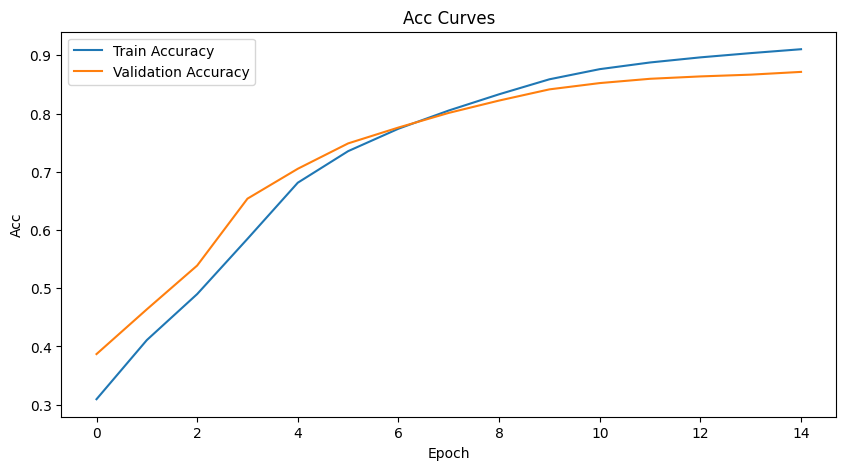

In [36]:
trainer.plot_acc()

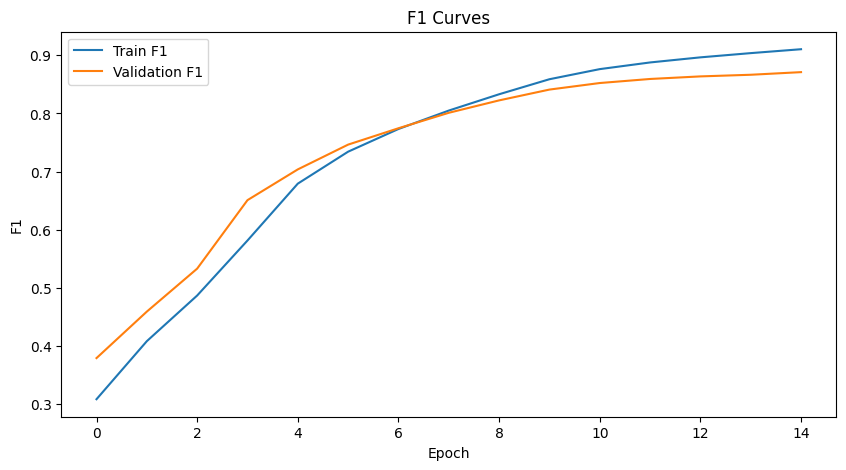

In [37]:
trainer.plot_f1()

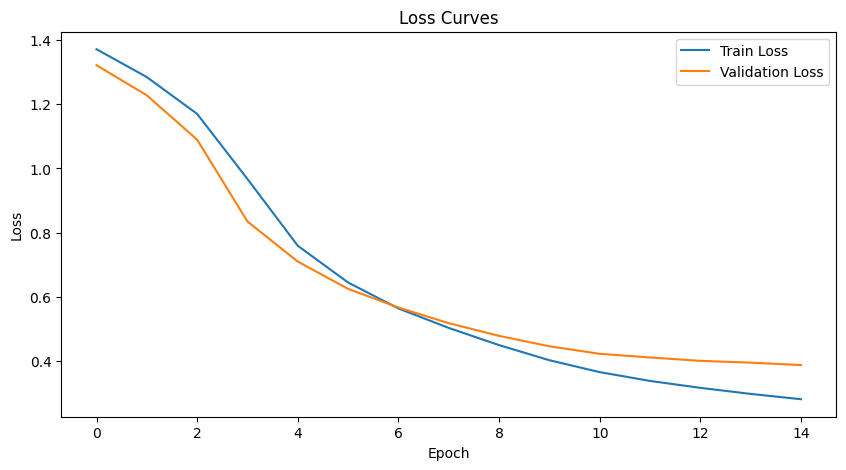

In [38]:
trainer.plot_losses()